# Water detection by Semantic Segmentation using SAR Satellite images

In [1]:
# import the libraries as shown below
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [2]:
import os
import random
import numpy as np

In [3]:
!pip install tqdm

In [4]:
from tqdm import tqdm 

In [5]:
!pip install scikit-image

In [6]:
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

In [8]:
# re-size all the images to this
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [9]:
# choose the train and test data path
TRAIN_PATH = 'train_data/'
TEST_PATH = 'test_data/'

In [10]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [11]:
train_ids

['1',
 '10',
 '100',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [12]:
test_ids

['water_body_1',
 'water_body_2',
 'water_body_3',
 'water_body_4',
 'water_body_5']

In [13]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [14]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   



Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.40it/s]


In [15]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
#sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    #sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.09it/s]

Resizing test images
Done!


In [16]:
len(test_ids)

5

In [17]:
X_train.size

4915200

In [18]:
X_test.size

245760

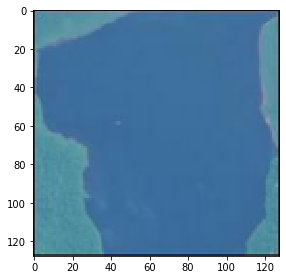

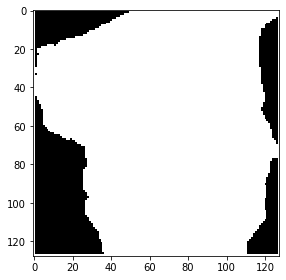

In [23]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [25]:

#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


In [26]:
#Contraction path/Encoding
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [27]:
#Expansive path/Decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 

In [28]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [29]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [32]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_water_segmentation.h5', verbose=1, save_best_only=True)

callback = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]

history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callback)

Epoch 1/25
6/6 [==============================] - 13s 2s/step - loss: 0.4987 - accuracy: 0.7534 - val_loss: 0.5095 - val_accuracy: 0.6919
Epoch 2/25
6/6 [==============================] - 12s 2s/step - loss: 0.4949 - accuracy: 0.7577 - val_loss: 0.5317 - val_accuracy: 0.6792
Epoch 3/25
6/6 [==============================] - 12s 2s/step - loss: 0.4934 - accuracy: 0.7584 - val_loss: 0.5061 - val_accuracy: 0.7096
Epoch 4/25
6/6 [==============================] - 13s 2s/step - loss: 0.4890 - accuracy: 0.7499 - val_loss: 0.5460 - val_accuracy: 0.6684
Epoch 5/25
6/6 [==============================] - 12s 2s/step - loss: 0.4834 - accuracy: 0.7608 - val_loss: 0.5131 - val_accuracy: 0.6853


In [33]:
from tensorflow.keras.models import load_model

model.save('model_for_water_segmentation.h5')

In [34]:
idx = random.randint(0, len(X_train))


# the first 90% was used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# the last 10% used as validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
# the predict test used as verification
preds_test = model.predict(X_test, verbose=1)

 # Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


1/1 [==============================] - 0s 159ms/step


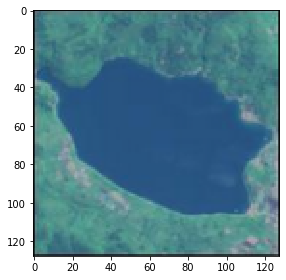

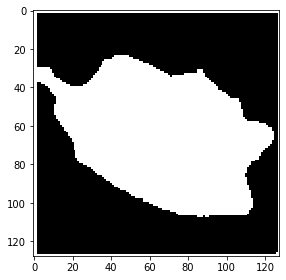

C:\Users\laiju\anaconda3\envs\cell\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


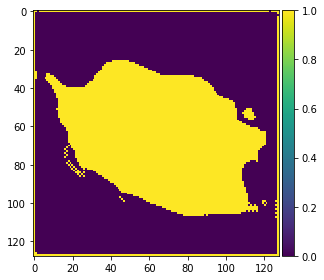

In [35]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

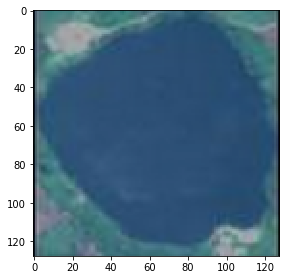

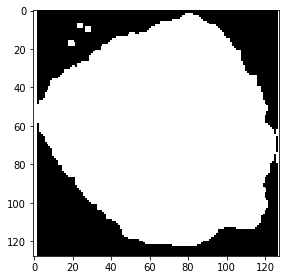

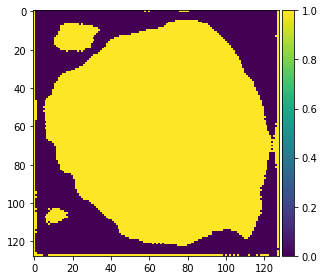

In [53]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

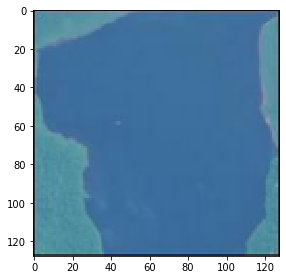

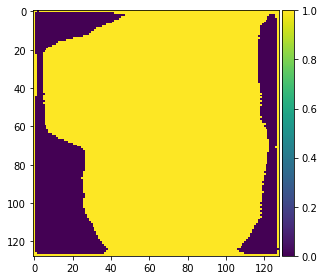

In [42]:
# Perform prediction on some random test samples
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()se

In [43]:
# Perform prediction on given sample
SINGLE_PREDICTION_PATH = 'single_prediction/'

In [44]:
single_prediction_id = next(os.walk(SINGLE_PREDICTION_PATH))[1]

In [45]:
single_prediction_id

['water_body_159']

In [46]:
X_single_prediction = np.zeros((len(single_prediction_id), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_single_prediction = []
print('Resizing single prediction image') 
for n, id_ in tqdm(enumerate(single_prediction_id), total=len(single_prediction_id)):
    path = SINGLE_PREDICTION_PATH + id_
    img = imread(path+'/images/'+ id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_single_prediction.append([img.shape[0], img.shape[1]])
    img_1 = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_single_prediction[n] = img_1

#print('Done!')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 38.48it/s]

Resizing single prediction image


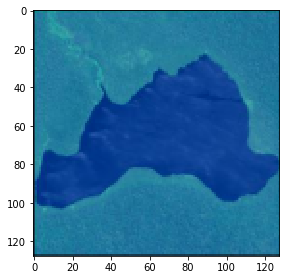

In [47]:
imshow(X_single_prediction[n])
#plt.show(X_single_prediction[n])

In [48]:
single_preds_test = model.predict(X_single_prediction, verbose=1)

single_preds_test_t = (single_preds_test > 0.5).astype(np.uint8)

1/1 [==============================] - 0s 58ms/step


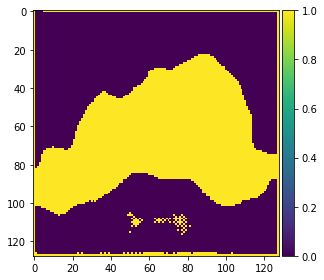

In [54]:

#imshow(X_train[ix])
#plt.show()
#imshow(np.squeeze(Y_train[ix]))
#plt.show()
imshow(np.squeeze(single_preds_test_t[n]))
plt.show()



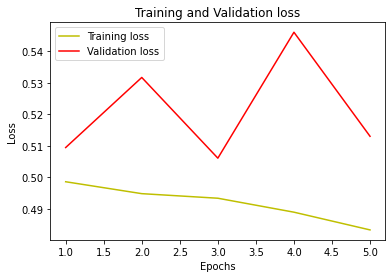

In [50]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss,'y',label='Training loss')
plt.plot(epochs, val_loss,'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

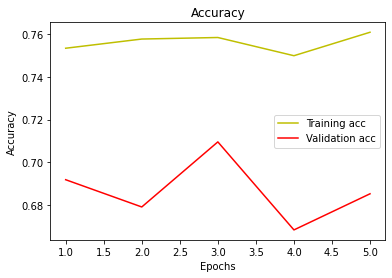

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1,len(loss)+1)
plt.plot(epochs, acc,'y',label='Training acc')
plt.plot(epochs, val_acc,'r',label='Validation acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()